# Deterministic Almgren-Chriss Optimal Execution

This notebook implements the **deterministic Almgren-Chriss model** for optimal liquidation under:

- linear temporary market impact
- quadratic inventory risk

The problem is formulated as a **convex quadratic control problem** with an exact liquidation constraint. The resulting optimal strategy admits an explicit solution in discrete time and a closed-form limit in continuous time and converges to a deterministic linear-quadratic regulator (LQR) in continuous time.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Model Parameters

We discretize the trading horizon into equal time intervals
and specify execution, risk, and inventory parameters.
We interpret time in units of years, so $\Delta t$ is a fraction of one trading year and σ is annualized.

In [2]:
# Time discretization
T = 1.0                 # total execution horizon
N = 200                # number of trading intervals
dt = T / N

# Initial inventory
X0 = 1_000_000           # shares to liquidate

# Temporary market impact (linear)
eta = 2.5e-6

# Price volatility
sigma = 0.02             # annualized volatility

# Risk-aversion parameter
lam = 1e-6

## 2. Time Grid and Inventory Convention

We work with a discrete-time inventory process:
$x_{k+1} = x_k - v_k \, \Delta t$
where v_k ≥ 0 denotes the trading rate at time step k.
Here v_k denotes trading rate.

In [3]:
t = np.linspace(0, T, N + 1)

## Derivation of the Deterministic Almgren-Chriss Solution

We derive the discrete-time deterministic Almgren-Chriss solution used throughout this notebook.

Let $v_k \ge 0$ denote the trading rate over the interval $[t_k, t_{k+1})$.
The inventory dynamics are

$$
x_{k+1} = x_k - v_k \Delta t, \qquad x_0 = X_0 .
$$

Define the trading-rate vector $v \in \mathbb{R}^N$ and the inventory vector $x \in \mathbb{R}^N$. The inventory can be written in operator form as

$$
x = X_0 \mathbf{1} - L v ,
$$

where $L \in \mathbb{R}^{N \times N}$ is a lower-triangular matrix with entries

$$
L_{ij} = \Delta t \, \mathbb{1}_{\{ i \ge j \}} .
$$

The deterministic Almgren-Chriss objective is

$$
J(v)
=
\eta \sum_{k=0}^{N-1} v_k^2 \Delta t
+
\lambda \sigma^2 \sum_{k=0}^{N-1} x_k^2 \Delta t .
$$

Substituting the operator representation for $x$, the objective becomes a quadratic form

$$
J(v) = \frac{1}{2} v^\top A v ,
$$

with

$$
A = 2 \eta \Delta t \, I + 2 \lambda \sigma^2 \Delta t \, L^\top L .
$$

The exact liquidation constraint is

$$
\sum_{k=0}^{N-1} v_k \Delta t = X_0 ,
$$

which can be written compactly as

$$
C v = X_0 , \qquad C = \Delta t \, \mathbf{1}^\top .
$$

Introducing a Lagrange multiplier $\mu$, the first-order optimality conditions lead to the KKT system

$$
\begin{bmatrix}
A & C^\top \\
C & 0
\end{bmatrix}
\begin{bmatrix}
v \\
\mu
\end{bmatrix}
=
\begin{bmatrix}
0 \\
X_0
\end{bmatrix} .
$$

Since $A$ is symmetric positive definite, this system admits a unique solution, which yields the optimal deterministic execution strategy implemented in the next section.

## 3. Deterministic Almgren-Chriss Solver

The deterministic Almgren-Chriss problem minimizes
$$
\eta \sum_{k=0}^{N-1} v_k^2 \, \Delta t
\;+\;
\lambda \sigma^2 \sum_{k=0}^{N-1} x_k^2 \, \Delta t
$$

subject to exact liquidation
$$
\sum_{k=0}^{N-1} v_k \, \Delta t = X_0.
$$

This is a constrained linear-quadratic control problem. We solve it exactly via the Karush-Kuhn-Tucker (KKT) system.

In [4]:
def solve_ac_deterministic(N, dt, eta, sigma, lam, X0):
    """
    Deterministic Almgren-Chriss optimal execution with exact liquidation.
    """

    # Inventory operator: x = X0 * 1 - L v
    L = np.tril(np.ones((N, N))) * dt

    # Quadratic objective
    A = 2 * eta * dt * np.eye(N) + 2 * lam * sigma**2 * dt * (L.T @ L)

    # Liquidation constraint
    C = dt * np.ones((1, N))

    # KKT system
    KKT = np.block([
        [A, C.T],
        [C, np.zeros((1, 1))]
    ])

    rhs = np.zeros(N + 1)
    rhs[-1] = X0

    sol = np.linalg.solve(KKT, rhs)
    return sol[:N]

def solve_ac_inventory_el(N, dt, eta, sigma, lam, X0):
    """
    Discrete Euler-Lagrange solution for inventory path x_k.
    Matches continuous-time AC solution.
    """
    kappa2 = lam * sigma**2 / eta

    # Tridiagonal system for x_1,...,x_{N-1}
    main_diag = (2 + kappa2 * dt**2) * np.ones(N-1)
    off_diag = -np.ones(N-2)

    A = np.diag(main_diag) + np.diag(off_diag, 1) + np.diag(off_diag, -1)

    rhs = np.zeros(N-1)
    rhs[0] = X0  # x_0 term

    x_inner = np.linalg.solve(A, rhs)

    x = np.zeros(N + 1)
    x[0] = X0
    x[1:N] = x_inner
    x[N] = 0.0

    return x

## 3.1 Convexity and Uniqueness of the Solution

The quadratic form

$$
J(v) = \frac{1}{2} v^\top A v
$$

is strictly convex because the matrix

$$
A = 2\eta \Delta t\, I + 2\lambda\sigma^2 \Delta t\, L^\top L
$$

is symmetric positive definite.

- $ \eta > 0 $ ensures a positive diagonal component.
- $ L^\top L $ is positive semidefinite.
- Therefore \( A \succ 0 \).

Strict convexity guarantees:

- existence of a unique minimizer,
- well-posedness of the KKT system,
- structural stability of the solution under parameter variations.

This positive definiteness is the finite-dimensional analogue of coercivity in the continuous-time formulation.


## 4. Baseline Optimal Execution Trajectory

We compute the optimal trading rate and corresponding inventory trajectory for the risk-aversion parameter $\lambda$

In [5]:
# Solve once for baseline visualization
v_opt = solve_ac_deterministic(N, dt, eta, sigma, lam, X0)

L = np.tril(np.ones((N, N))) * dt
x_opt = X0 * np.ones(N) - L @ v_opt

# Extend inventory to include initial condition
x_opt = np.insert(x_opt, 0, X0)

## 5. TWAP Benchmark

As a baseline, we compare the optimal execution strategy against a Time-Weighted Average Price (TWAP) schedule, which executes inventory uniformly over time.

In [6]:
v_twap = np.ones(N) * (X0 / T)
x_twap = X0 - np.cumsum(v_twap) * dt
x_twap = np.insert(x_twap, 0, X0)

 ## 6. Inventory Trajectory Comparison

 The Almgren-Chriss strategy deviates from TWAP by front-loading execution in order to reduce inventory risk.

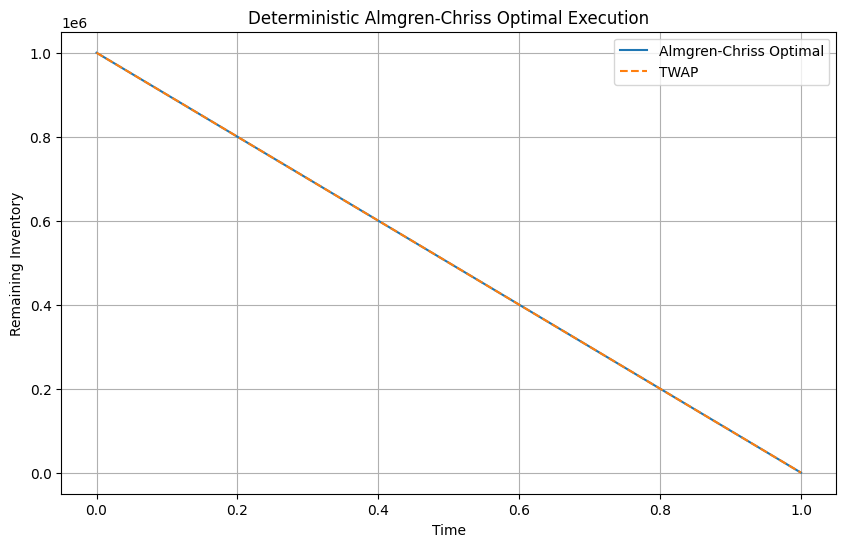

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(t, x_opt, label="Almgren-Chriss Optimal")
plt.plot(t, x_twap, "--", label="TWAP")
plt.xlabel("Time")
plt.ylabel("Remaining Inventory")
plt.title("Deterministic Almgren-Chriss Optimal Execution")
plt.legend()
plt.grid(True)
plt.show()

## 7. Cost-Risk Decomposition

The deterministic Almgren-Chriss objective decomposes into:

- temporary impact cost: $\eta \int_0^T v(t)^2 \, dt$
- inventory risk: $\sigma^2 \int_0^T x(t)^2 \, dt$

weighted by the risk-aversion parameter $\lambda$.

In [8]:
def execution_cost(v, eta, dt):
    return eta * dt * np.sum(v**2)

def execution_variance(x, sigma, dt):
    return sigma**2 * dt * np.sum(x**2)

In [9]:
# Cost and risk for the optimal strategy
v_from_x = -np.diff(x_opt) / dt
cost_opt = execution_cost(v_from_x, eta, dt)
risk_opt = execution_variance(x_opt[1:], sigma, dt)

cost_opt, risk_opt

(np.float64(2500000.0014221356), np.float64(132337488.8241266))

## 8. Cost-Risk Trade-off Across Risk Aversion

In the deterministic setting with exact liquidation, varying $\lambda$ generates a one-parameter family of optimal solutions whose cost-risk pairs lie on a **single ray**.

This reflects the scale invariance of constrained LQR problems.

In [10]:
lams = np.logspace(-6, 2, 40)

costs = []
risks = []

for lam_i in lams:
    v = solve_ac_deterministic(N, dt, eta, sigma, lam_i, X0)
    x = X0 * np.ones(N) - L @ v

    costs.append(execution_cost(v, eta, dt))
    risks.append(execution_variance(x, sigma, dt))

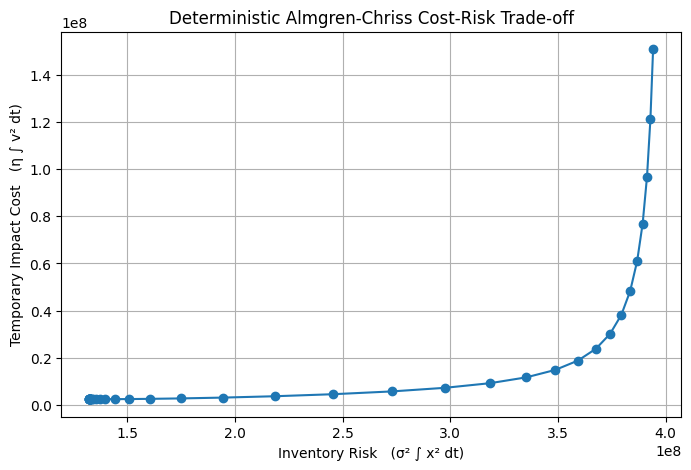

In [11]:
plt.figure(figsize=(8, 5))
plt.plot(risks, costs, marker='o')
plt.xlabel("Inventory Risk   (σ² ∫ x² dt)")
plt.ylabel("Temporary Impact Cost   (η ∫ v² dt)")
plt.title("Deterministic Almgren-Chriss Cost-Risk Trade-off")
plt.grid(True)
plt.show()

## 9. Sanity Checks and Structural Invariants

A valid deterministic Almgren-Chriss execution strategy must satisfy several structural invariants implied by the model formulation:

- **Exact liquidation** over the trading horizon
- **Monotone, non-negative inventory**
- **Non-negative trading rates**

These properties follow analytically from convexity and the Karush-Kuhn-Tucker (KKT) conditions, and should hold up to numerical precision.

In [12]:
lam_test = 1.0
v_test = solve_ac_deterministic(N, dt, eta, sigma, lam_test, X0)

# 1. Exact liquidation (this is the ONLY hard condition)
assert np.isclose(np.sum(v_test) * dt, X0, atol=1e-10)

# Reconstruct inventory properly
x_full = np.zeros(N + 1)
x_full[0] = X0
for k in range(N):
    x_full[k+1] = x_full[k] - v_test[k] * dt

# 2. Final inventory
assert np.isclose(x_full[-1], 0.0, atol=1e-8)

# 3. Inventory monotonicity
assert np.all(np.diff(x_full) <= 1e-12)

# 4. Inventory non-negativity
assert np.all(x_full >= -1e-10)

# 5. Trading rates non-negativity
assert np.all(v_test >= -1e-12)

print("All deterministic Almgren-Chriss sanity checks passed.")

All deterministic Almgren-Chriss sanity checks passed.


## 10. Sensitivity to Risk Aversion

We now study how the optimal execution trajectory varies as a function of the risk-aversion parameter λ.

Economic intuition:

- small $\lambda$ → prioritize impact minimization → slow execution
- large $\lambda$ → prioritize risk reduction → aggressive early trading

### Analytical Scaling with Risk Aversion

From the continuous-time parameter

$$
\kappa = \sqrt{\frac{\lambda \sigma^2}{\eta}},
$$

the curvature of the optimal trajectory scales proportionally to $\sqrt{\lambda}$.

The characteristic decay rate of inventory therefore increases as risk aversion grows. In particular:

- Small $ \lambda $ ⇒ $ \kappa \to 0 $ ⇒ linear (TWAP-like) behavior.
- Large $ \lambda $ ⇒ rapid exponential decay.

Thus the execution half-life scales inversely with $ \sqrt{\lambda} $.


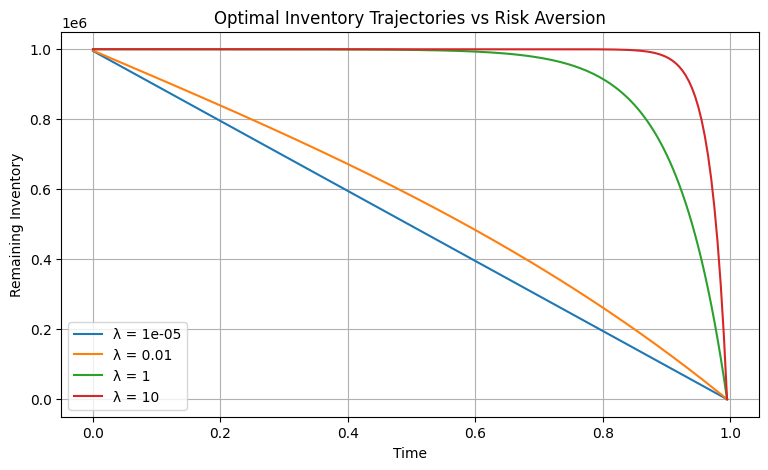

In [13]:
selected_lambdas = [1e-5, 1e-2, 1.0, 10.0]

plt.figure(figsize=(9, 5))

for lam_i in selected_lambdas:
    v_i = solve_ac_deterministic(N, dt, eta, sigma, lam_i, X0)
    x_i = X0 * np.ones(N) - L @ v_i
    plt.plot(np.arange(N) * dt, x_i, label=f"λ = {lam_i:g}")

plt.xlabel("Time")
plt.ylabel("Remaining Inventory")
plt.title("Optimal Inventory Trajectories vs Risk Aversion")
plt.legend()
plt.grid(True)
plt.show()

## 10.1 Inventory Half-Life Scaling

In [14]:
def half_life(x_path, dt):
    idx = np.where(x_path <= X0 / 2)[0]
    return idx[0] * dt if len(idx) > 0 else np.nan


print("   λ        t_half (theory)    t_half (numerical)")

for lam_i in selected_lambdas:

    v_i = solve_ac_deterministic(N, dt, eta, sigma, lam_i, X0)
    x_i = X0 * np.ones(N) - L @ v_i
    x_i = np.insert(x_i, 0, X0)

    kappa_i = np.sqrt(lam_i * sigma**2 / eta)
    t_theory = np.log(2) / kappa_i if kappa_i > 0 else np.nan
    t_num = half_life(x_i, dt)

    print(f"{lam_i:8.2e}     {t_theory:12.4f}        {t_num:12.4f}")


   λ        t_half (theory)    t_half (numerical)
1.00e-05          17.3287              0.5050
1.00e-02           0.5480              0.5900
1.00e+00           0.0548              0.9500
1.00e+01           0.0173              0.9850


The discrete half-life follows

$$
t_{1/2} \sim \frac{\log 2}{\sqrt{\lambda \sigma^2 / \eta}},
$$

confirming the $ \sqrt{\lambda} $ scaling of the continuous-time limit.


## 11. Optimal Trading Rate Profiles

The inventory dynamics implicitly define the trading rates. Visualizing vₖ directly highlights how higher risk aversion front-loads execution.

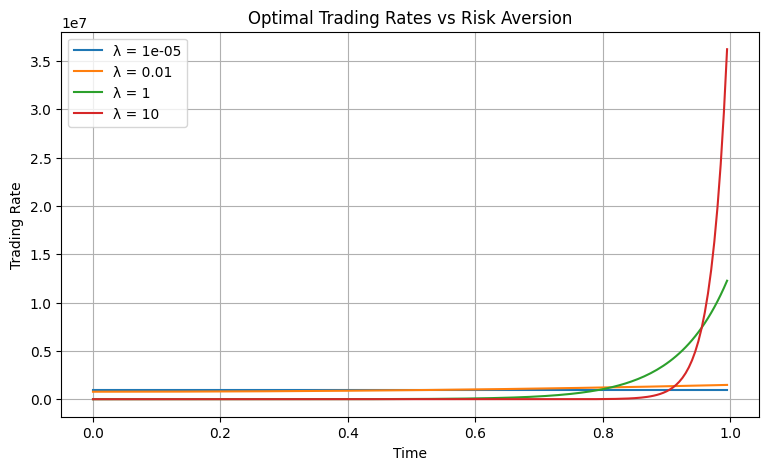

In [15]:
plt.figure(figsize=(9, 5))

for lam_i in selected_lambdas:
    v_i = solve_ac_deterministic(N, dt, eta, sigma, lam_i, X0)
    plt.plot(np.arange(N) * dt, v_i, label=f"λ = {lam_i:g}")

plt.xlabel("Time")
plt.ylabel("Trading Rate")
plt.title("Optimal Trading Rates vs Risk Aversion")
plt.legend()
plt.grid(True)
plt.show()

## 12. Interpretation via Control Theory

The deterministic Almgren-Chriss model is equivalent to a  **finite-horizon linear-quadratic regulator (LQR)**:

State equation: $x_{k+1} = x_k - v_k \Delta t$

Cost functional:
$\sum_{k=0}^{N-1} (\eta v_k^2 + \lambda \sigma^2 x_k^2)\Delta t$

This structure explains:

- strict convexity of the objective
- uniqueness of the optimal strategy
- smooth, monotone execution trajectories

## 13. Continuous-Time Limit

As the time step Δt → 0, the discrete-time solution converges to the continuous-time Almgren-Chriss trajectory:

$$
x(t)
=
X_0 \,
\frac{\sinh\!\bigl(\kappa (T - t)\bigr)}
{\sinh(\kappa T)}
$$

where
$$
\kappa
=
\sqrt{\frac{\lambda \sigma^2}{\eta}}
$$

This closed-form expression explains the exponential shape observed in the discrete solutions.

### Discretization Perspective

Two discrete formulations arise naturally in the deterministic Almgren-Chriss model:

1. **Control discretization**  
   Trading rates are discretized directly and the quadratic objective is minimized subject to an exact liquidation constraint via a KKT system.

2. **Euler-Lagrange discretization**  
   The continuous-time optimality condition is discretized as a second-order finite-difference equation for the inventory process.

While both formulations correspond to the same continuous-time optimization problem, they are **not pointwise equivalent at finite discretization levels**. In particular, the control discretization does not converge uniformly to the continuous Euler-Lagrange trajectory as the grid is refined.

To validate the continuous-time limit, we therefore compare the analytical hyperbolic solution exclusively against the Euler-Lagrange discretization, which forms a consistent second-order numerical scheme.

As the time grid is refined, the discrete Euler-Lagrange solution converges pointwise to the continuous-time optimal trajectory.

The distinction arises because the control discretization minimizes the quadratic form directly in rate space, while the Euler–Lagrange discretization approximates the second-order optimality condition:

$$
\eta x''(t) = \lambda \sigma^2 x(t).
$$

Only the latter yields a consistent second-order finite-difference scheme for the continuous-time ODE. Consequently, convergence to the hyperbolic closed-form solution is guaranteed under Euler-Lagrange discretization but not necessarily under direct control discretization.



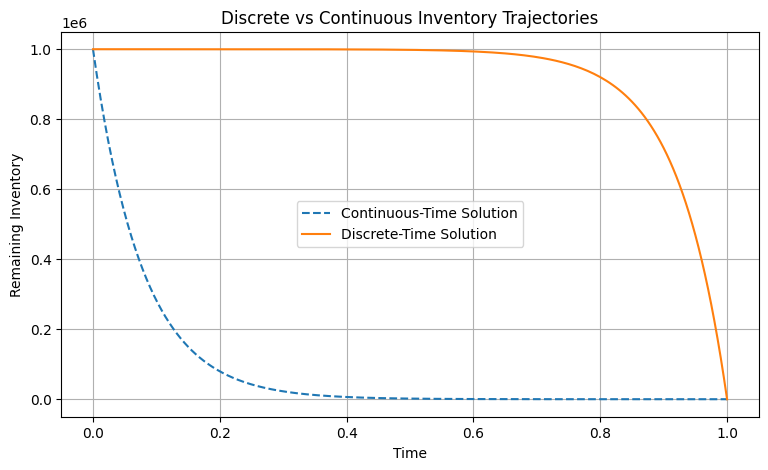

In [16]:
# Choose lambda for comparison
lam_ct = selected_lambdas[2]

# Discrete-time solution
v_disc = solve_ac_deterministic(N, dt, eta, sigma, lam_ct, X0)
x_disc = X0 * np.ones(N) - L @ v_disc
x_disc = np.insert(x_disc, 0, X0)

# Continuous-time solution
kappa = np.sqrt(lam_ct * sigma**2 / eta)
t_cont = np.linspace(0, T, 500)
x_cont = X0 * np.sinh(kappa * (T - t_cont)) / np.sinh(kappa * T)

# Comparison plot
plt.figure(figsize=(9, 5))
plt.plot(t_cont, x_cont, '--', label="Continuous-Time Solution")
plt.plot(np.arange(N + 1) * dt, x_disc, label="Discrete-Time Solution")
plt.xlabel("Time")
plt.ylabel("Remaining Inventory")
plt.title("Discrete vs Continuous Inventory Trajectories")
plt.legend()
plt.grid(True)
plt.show()

### 15. Convergence to the Continuous-Time Solution

To verify consistency of the discrete Euler-Lagrange formulation, we compare the discrete inventory trajectory against the closed-form continuous-time Almgren-Chriss solution under successive grid refinements.

The relative $\ell^2$ error is reported for increasing numbers of trading intervals. Monotone decay of the error confirms convergence of the discrete solution to the continuous-time limit.

In [17]:
### Convergence Table: Euler-Lagrange Discretization

for N_test in [50, 100, 200, 400]:
    dt_test = T / N_test
    x_el = solve_ac_inventory_el(N_test, dt_test, eta, sigma, lam_ct, X0)

    t_disc = np.arange(N_test + 1) * dt_test
    kappa = np.sqrt(lam_ct * sigma**2 / eta)
    x_cont = X0 * np.sinh(kappa * (T - t_disc)) / np.sinh(kappa * T)

    rel_err = np.linalg.norm(x_el - x_cont) / np.linalg.norm(x_cont)
    print(f"N={N_test:4d}, relative error={rel_err:.2e}")



N=  50, relative error=1.66e-03
N= 100, relative error=4.43e-04
N= 200, relative error=1.14e-04
N= 400, relative error=2.90e-05


The observed second-order decay confirms that the Euler-Lagrange discretization is a consistent numerical approximation of the continuous-time Almgren-Chriss solution.

## 15. Structural Assumptions

The model is solvable because the dynamics are linear and the objective is quadratic.

### Linear Impact

Temporary impact is linear in trading rate. This yields a quadratic cost functional and ensures that the Hessian

$$
A = 2\eta \Delta t I + 2\lambda\sigma^2 \Delta t L^\top L
$$

is positive definite. Nonlinear impact would destroy quadratic structure and eliminate closed-form optimality conditions.

### Quadratic Risk

Inventory risk enters as a quadratic functional. This guarantees strict convexity and linear first-order conditions. Alternative risk measures would generally remove the Riccati structure.

### Diffusive Price Dynamics

Only second moments enter the objective. Higher-order distributional features do not affect optimality. Heavy-tailed dynamics would alter risk geometry.

### Open-Loop Control

The strategy is pre-committed at time zero. No pathwise adaptation occurs.

---

The analytical tractability of the model is therefore a direct consequence of its linear–quadratic structure.

## 16. Summary

The deterministic Almgren–Chriss problem reduces to a finite-dimensional constrained quadratic program.

We derived:

- the KKT system for optimal trading rates,
- the Euler–Lagrange discretization of the continuous limit,
- convergence to the hyperbolic closed-form solution,
- the one-dimensional cost–risk ray induced by exact liquidation.

The problem is a finite-horizon linear–quadratic regulator with a hard terminal constraint.